In [26]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from numba import jit, prange, njit
from blimpy import Waterfall
import time
import random
from synthetic_real_dynamic_edit import create_true, create_full_cadence, create_false, create_true_single_shot, create_true_faster
import math
from sklearn.metrics import silhouette_score
import sys
sys.path.insert(1, '../ML_Training')
sys.path.insert(2, '../GBT_pipeline')
sys.path.insert(3, '../test_bench')
from preprocess_dynamic import get_data
from single_search import search_model_eval, combine
from skimage.transform import rescale, resize, downscale_local_mean
import gc
from data_generation import create_data_set
from sklearn.tree import DecisionTreeClassifier


gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
        tf.config.experimental.set_virtual_device_configuration(
            gpus[1],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
        tf.config.experimental.set_virtual_device_configuration(
            gpus[2],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        tf.config.experimental.set_virtual_device_configuration(
            gpus[3],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 4 Logical GPUs


In [75]:
NUM_SAMPLES = 3
plate = np.load('../../../../../../../datax/scratch/pma/real_filtered_LARGE_HIP13402.npy')

print(plate.shape)

(14567, 6, 16, 4096)


In [77]:
index = 0
print(plate[index,0,:,:].max())
print(plate[index,1,:,:].max())
print(plate[index,2,:,:].max())
print(plate[index,3,:,:].max())
print(plate[index,4,:,:].max())

55783102349312.0
55941240193024.0
56078792392704.0
56248481349632.0
55656044298240.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  import sys


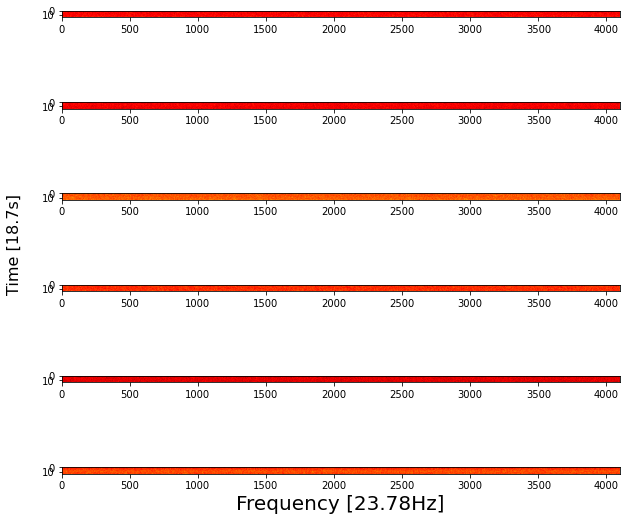

In [78]:
plot_cadence(plate[1, :,:,:])

In [79]:
print(plate.shape)
data, false_data_train, true_data_train = create_data_set(plate, NUM_SAMPLES=NUM_SAMPLES, snr_base=20, snr_range = 50, factor=1)
del  data
gc.collect()

(14567, 6, 16, 4096)
Creating True
(3, 6, 16, 4096)
(3, 6, 16, 4096) (3, 6, 16, 512)
(3, 6, 16, 512)
(18, 16, 512, 1)
Creating False
(18, 6, 16, 4096) (18, 6, 16, 512)
(18, 6, 16, 512)
Creating True
(9, 6, 16, 4096) (9, 6, 16, 512)
(9, 6, 16, 512)
(9, 6, 16, 4096) (9, 6, 16, 512)
(9, 6, 16, 512)
(18, 6, 16, 512, 1)


0

In [44]:
print(false_data_train[3, 0,:,:,0].max())
print(false_data_train[3, 4,:,:,0].max())

0.6198503137815237
1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  import sys


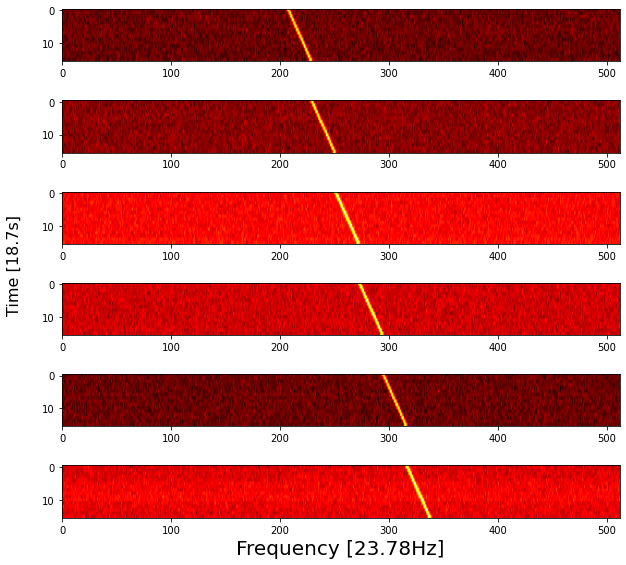

In [81]:
plot_cadence(false_data_train[0, :,:,:,0])

In [30]:
NUM_SAMPLES = 3
plate_test = np.load('../../../../../../../datax/scratch/pma/real_filtered_LARGE_test_HIP15638.npy')

In [31]:
print(plate_test.shape)
NUM_SAMPLES = 3
data, false_data_test, true_data_test = create_data_set(plate_test, NUM_SAMPLES=NUM_SAMPLES, snr_base=20, snr_range = 50, factor=1)
del plate_test, data
gc.collect()

(14567, 6, 16, 4096)
Creating True
(3, 6, 16, 4096)
(3, 6, 16, 4096) (3, 6, 16, 512)
(3, 6, 16, 512)
(18, 16, 512, 1)
Creating False
(18, 6, 16, 4096) (18, 6, 16, 512)
(18, 6, 16, 512)
Creating True
(9, 6, 16, 4096) (9, 6, 16, 512)
(9, 6, 16, 512)
(9, 6, 16, 4096) (9, 6, 16, 512)
(9, 6, 16, 512)
(18, 6, 16, 512, 1)


0

In [ ]:
print("reshape")
true_data_train_unroll = np.reshape(true_data_train, (true_data_train.shape[0], true_data_train.shape[1]*true_data_train.shape[2]*true_data_train.shape[3]))
false_data_train_unroll = np.reshape(false_data_train, (false_data_train.shape[0], false_data_train.shape[1]*false_data_train.shape[2]*false_data_train.shape[3]))
print("reshape")
true_data_test_unroll = np.reshape(true_data_test, (true_data_test.shape[0], true_data_test.shape[1]*true_data_test.shape[2]*true_data_test.shape[3]))
false_data_test_unroll = np.reshape(false_data_test, (false_data_test.shape[0], false_data_test.shape[1]*false_data_test.shape[2]*false_data_test.shape[3]))

In [7]:
from sklearn.utils import shuffle
import numpy as np


train_unroll = np.concatenate((true_data_train_unroll,false_data_train_unroll))
print(train_unroll.shape)
true_labels = np.ones((true_data_train_unroll.shape[0]))

false_labels = np.zeros((false_data_train_unroll.shape[0]))
labels = np.concatenate((true_labels,false_labels))
print(labels.shape)
train_unroll, labels = shuffle(train_unroll, labels)

(36000, 49152)
(36000,)


In [8]:
test_unroll = np.concatenate((true_data_test_unroll,false_data_test_unroll))
print(test_unroll.shape)
true_test_labels = np.ones((true_data_test_unroll.shape[0]))

false_test_labels = np.zeros((false_data_test_unroll.shape[0]))
test_labels = np.concatenate((true_test_labels,false_test_labels))
print(test_labels.shape)
test_unroll, test_labels = shuffle(test_unroll, test_labels)

(6000, 49152)
(6000,)


In [9]:
print(test_labels)

[0. 0. 1. ... 0. 0. 1.]


In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=48)
smaller_train = pca.fit_transform(train_unroll)
smaller_test = pca.fit_transform(test_unroll)
print(smaller_train.shape)

(36000, 48)


# Random Forest Decision Tree

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
tree = RandomForestClassifier(n_estimators=1000, 
                               bootstrap = True,
                               max_features = 'sqrt',n_jobs=-1)
# Fit on training data
tree.fit(smaller_train, labels)

RandomForestClassifier(max_features='sqrt', n_estimators=1000, n_jobs=-1)

In [12]:
# Actual class predictions
print(smaller_test.shape)
rf_predictions = tree.predict(smaller_test)
# Probabilities for each class
rf_probs = tree.predict_proba(smaller_test)[:, 1]

(6000, 48)


In [13]:
from sklearn.metrics import roc_auc_score

# Calculate roc auc
roc_value = roc_auc_score(test_labels, tree.predict_proba(smaller_test)[:, 1])
print(roc_value)

0.7369034999999999


In [14]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels,  tree.predict(smaller_test))

0.699

In [15]:
%matplotlib inline
from sklearn import metrics

fpr_tree, tpr_tree, _ = metrics.roc_curve(test_labels,  tree.predict_proba(smaller_test)[:, 1])
auc_rf= metrics.roc_auc_score(test_labels, tree.predict(smaller_test))
print(auc_rf)

0.6990000000000001


# SVM


In [16]:
from sklearn import svm

SVM = svm.SVC()
SVM.fit(smaller_train, labels)

SVC()

In [17]:
probs = SVM.predict(smaller_test)

roc_value = roc_auc_score(test_labels, probs)
print(roc_value)

accuracy_score(test_labels, SVM.predict(smaller_test))

from sklearn import metrics

fpr_svm, tpr_svm, _ = metrics.roc_curve(test_labels,   SVM.predict(smaller_test))
auc_svm= metrics.roc_auc_score(test_labels, SVM.predict(smaller_test))
print(auc_svm)

0.6953333333333334
0.6953333333333334


# Artifical Neural Network

In [18]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from numba import jit, prange, njit
from blimpy import Waterfall
import time
import random
import datetime
from synthetic_real_dynamic import create_true, create_full_cadence, create_false, create_true_single_shot, create_true_faster
from scipy import spatial
from numpy import dot
from numpy.linalg import norm
import math
from sklearn.metrics import silhouette_score
import sys
sys.path.insert(1, '../ML_Training')
sys.path.insert(2, '../GBT_pipeline')
from preprocess_dynamic import get_data
from single_search import search_model_eval, combine
from skimage.transform import rescale, resize, downscale_local_mean
import gc
from keras.regularizers import l1, l2
from data_generation import create_data_set

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
        tf.config.experimental.set_virtual_device_configuration(
            gpus[1],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
        tf.config.experimental.set_virtual_device_configuration(
            gpus[2],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        tf.config.experimental.set_virtual_device_configuration(
            gpus[3],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 4 Logical GPUs


In [19]:
from tensorflow.python.client import device_lib
gpus = tf.config.experimental.list_physical_devices('GPU')

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(smaller_train, labels, test_size=0.2)
print(X_train.shape)

(28800, 48)


In [21]:
model = Sequential()
model.add(Dense(512, input_dim=48, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.summary()
model.fit(X_train, y_train, epochs=150, batch_size=1000, 
          validation_data=(X_test, y_test),validation_batch_size=1000)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               25088     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 190,353
Trainable params: 190,353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
29/29 [==============================] - 5s 58ms/step - loss: 0.6217 - accuracy: 0.6232 - val_loss: 0.55

Epoch 109/150
29/29 [==============================] - 0s 6ms/step - loss: 0.2055 - accuracy: 0.8997 - val_loss: 0.5817 - val_accuracy: 0.7781
Epoch 110/150
29/29 [==============================] - 0s 6ms/step - loss: 0.2018 - accuracy: 0.8971 - val_loss: 0.5873 - val_accuracy: 0.7794
Epoch 111/150
29/29 [==============================] - 0s 6ms/step - loss: 0.2290 - accuracy: 0.8816 - val_loss: 0.5895 - val_accuracy: 0.7782
Epoch 112/150
29/29 [==============================] - 0s 6ms/step - loss: 0.2072 - accuracy: 0.8936 - val_loss: 0.5841 - val_accuracy: 0.7769
Epoch 113/150
29/29 [==============================] - 0s 6ms/step - loss: 0.1969 - accuracy: 0.8991 - val_loss: 0.6126 - val_accuracy: 0.7789
Epoch 114/150
29/29 [==============================] - 0s 6ms/step - loss: 0.1917 - accuracy: 0.9042 - val_loss: 0.6134 - val_accuracy: 0.7760
Epoch 115/150
29/29 [==============================] - 0s 6ms/step - loss: 0.1949 - accuracy: 0.9028 - val_loss: 0.6393 - val_accuracy: 0.7772

In [22]:
accuracy_score( test_labels, model.predict_classes(smaller_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.6361666666666667

In [23]:
roc_value = roc_auc_score( test_labels, model.predict(smaller_test))
print(roc_value)
from sklearn import metrics

fpr_ann, tpr_ann, _ = metrics.roc_curve(test_labels,   model.predict(smaller_test))
auc_ann = metrics.roc_auc_score(test_labels, model.predict(smaller_test))
print(auc_ann)

0.6933647777777778
0.6933647777777778


# 3-D Convolutional Neural Net

In [8]:
import tensorflow as tf
import keras
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.layers.core import Activation, Flatten
import matplotlib.pyplot as plt
from keras.optimizers import SGD,RMSprop
from keras.models import load_model
from keras.losses import binary_crossentropy
from keras.utils import np_utils
import os, os.path
import numpy as np
import tempfile
from keras.layers import Reshape
from keras import losses
from keras.layers.advanced_activations import LeakyReLU 
from keras.activations import sigmoid
from keras.layers import Input, LSTM, MaxPooling1D, Conv1D
from keras.models import Model
from keras import backend as K
from keras.layers.convolutional import Convolution1D
from keras.layers import  Conv2D, MaxPool3D, MaxPooling2D, TimeDistributed, Embedding, Convolution2D , Lambda
from keras.layers import BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping, ModelCheckpoint
from blimpy import Waterfall
from keras.layers import Reshape, Conv2DTranspose, BatchNormalization, ZeroPadding2D
from keras.layers import Softmax
from  keras.backend import expand_dims
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from random import seed
from random import random
import time 
import datetime
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy.stats import lognorm

from scipy import stats

In [ ]:
from sklearn.utils import shuffle
import numpy as np


train = np.concatenate((true_data_train,false_data_train))
print(train.shape)
true_labels = np.ones((true_data_train.shape[0]))

false_labels = np.zeros((false_data_train.shape[0]))
labels = np.concatenate((true_labels,false_labels))
print(labels.shape)
train, labels = shuffle(train, labels)

In [ ]:
test = np.concatenate((true_data_test,false_data_test))
print(test.shape)
true_test_labels = np.ones((true_data_test.shape[0]))
true_labels[:]=1

false_test_labels = np.zeros((false_data_test.shape[0]))
false_test_labels[:]=0
test_labels = np.concatenate((true_test_labels,false_test_labels))
print(test_labels.shape)
test, test_labels = shuffle(test, test_labels)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.2)
print(X_train.shape)

(28800, 6, 16, 512, 1)


In [28]:
def build_model():
    input_size = X_train.shape[1:]
    model = Sequential()
    
    model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same', 
                     input_shape=(6,16,512,1)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(Dropout(0.5))
    
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(Dropout(0.5))
    
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=['accuracy'])
    model.summary()

    return model

In [29]:
strategy = tf.distribute.MirroredStrategy(
    cross_device_ops=tf.distribute.ReductionToOneDevice())
print("Number of devices: {}".format(strategy.num_replicas_in_sync))


with strategy.scope():
    model_conv = build_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
tensorflow      INFO     Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
tensorflow      INFO     Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
tensorflow      INFO     Reduce to /job:localhost/r

In [30]:
history = model_conv.fit(X_train, y_train,epochs=150, batch_size=500, shuffle=True, 
                validation_data=(X_test, y_test)) 

Epoch 1/150
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
tensorflow      INFO     Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
tensorflow      INFO     Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:

Epoch 18/150
58/58 [==============================] - 13s 220ms/step - loss: 0.5592 - accuracy: 0.6910 - val_loss: 0.7181 - val_accuracy: 0.5094
Epoch 19/150
58/58 [==============================] - 12s 208ms/step - loss: 0.5557 - accuracy: 0.6921 - val_loss: 0.7197 - val_accuracy: 0.5103
Epoch 20/150
58/58 [==============================] - 13s 221ms/step - loss: 0.5592 - accuracy: 0.6886 - val_loss: 0.7212 - val_accuracy: 0.5107
Epoch 21/150
58/58 [==============================] - 13s 217ms/step - loss: 0.5583 - accuracy: 0.6915 - val_loss: 0.7211 - val_accuracy: 0.5068
Epoch 22/150
58/58 [==============================] - 13s 217ms/step - loss: 0.5591 - accuracy: 0.6884 - val_loss: 0.6974 - val_accuracy: 0.5371
Epoch 23/150
58/58 [==============================] - 13s 227ms/step - loss: 0.5597 - accuracy: 0.6893 - val_loss: 0.7178 - val_accuracy: 0.5107
Epoch 24/150
58/58 [==============================] - 12s 209ms/step - loss: 0.5593 - accuracy: 0.6923 - val_loss: 0.7195 - val_ac

58/58 [==============================] - 12s 207ms/step - loss: 0.1266 - accuracy: 0.9385 - val_loss: 0.4320 - val_accuracy: 0.9092
Epoch 131/150
58/58 [==============================] - 12s 210ms/step - loss: 0.1294 - accuracy: 0.9420 - val_loss: 0.3039 - val_accuracy: 0.9162
Epoch 132/150
58/58 [==============================] - 12s 215ms/step - loss: 0.1270 - accuracy: 0.9407 - val_loss: 0.4779 - val_accuracy: 0.8999
Epoch 133/150
58/58 [==============================] - 12s 207ms/step - loss: 0.1222 - accuracy: 0.9439 - val_loss: 0.3571 - val_accuracy: 0.9164
Epoch 134/150
58/58 [==============================] - 12s 212ms/step - loss: 0.1304 - accuracy: 0.9427 - val_loss: 0.5030 - val_accuracy: 0.9039
Epoch 135/150
58/58 [==============================] - 13s 217ms/step - loss: 0.1225 - accuracy: 0.9427 - val_loss: 0.3334 - val_accuracy: 0.9187
Epoch 136/150
58/58 [==============================] - 12s 208ms/step - loss: 0.1186 - accuracy: 0.9461 - val_loss: 0.3934 - val_accuracy:

In [31]:
from sklearn import metrics

fpr_cnn, tpr_cnn, _ = metrics.roc_curve(test_labels,   model_conv.predict(test))
auc_conv = metrics.roc_auc_score(test_labels, model_conv.predict(test))
print(auc_conv)

0.9762512777777778


In [32]:
candidate_false = model_conv.predict(false_data_test)
candidate_true = model_conv.predict(true_data_test)

In [33]:
threshold = 0.5
count=0
for i in range(candidate_false.shape[0]):
    if candidate_false[i]<threshold:
        count+=1
print(count/candidate_false.shape[0])
count=0
for i in range(candidate_true.shape[0]):
    if candidate_true[i]>threshold:
        count+=1
print(count/candidate_true.shape[0])

0.9826666666666667
0.8846666666666667


# 002 Algorithm

In [34]:
import joblib
from execute_model import model_load

model_name = "../test_bench/VAE-BLPC1-ENCODER_compressed_512v13-0"
zeroTwo = model_load(model_name+".h5")
forest = joblib.load('../test_bench/random_forest_1000_v4.joblib')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
tensorflow      INFO     Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
tensorflow      WARNING  No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


In [35]:
print(test.shape)

(6000, 6, 16, 512, 1)


In [36]:
frame_list = []
for i in range(test.shape[0]):
    print(i)
    frame_list.append(zeroTwo.predict(test[i,:,:,:,:])[2].ravel())
frame_list = np.array(frame_list)
probs_list = forest.predict_proba(frame_list)[:, 1]
print(probs_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338


In [37]:
fpr_002, tpr_002, _ = metrics.roc_curve(test_labels,  probs_list)
auc_002= metrics.roc_auc_score(test_labels, probs_list)
print(auc_002)

0.9985534444444445


# ROC Curves

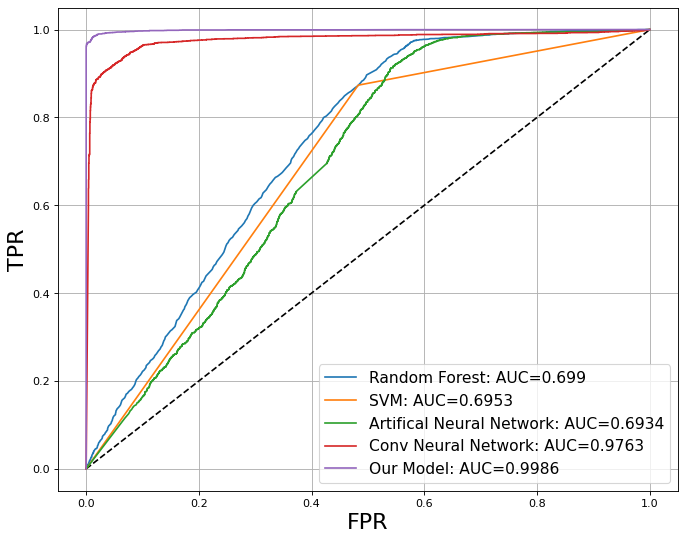

In [50]:
%matplotlib inline

plt.figure(figsize=(10, 8), dpi=80)
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr_tree, tpr_tree, label= "Random Forest: AUC="+str(round(auc_rf,4)))
plt.plot(fpr_svm, tpr_svm, label= "SVM: AUC="+str(round(auc_svm,4)))
plt.plot(fpr_ann, tpr_ann, label= "Artifical Neural Network: AUC="+str(round(auc_ann,4)))
plt.plot(fpr_cnn, tpr_cnn, label= "Conv Neural Network: AUC="+str(round(auc_conv,4)))
plt.plot(fpr_002, tpr_002, label= "Our Model: AUC="+str(round(auc_002,4)))         
plt.legend(fontsize=14)
plt.xlabel("FPR", fontsize=20)
plt.ylabel("TPR", fontsize=20)
plt.grid()
plt.show()

# Out of Sample Signals

In [32]:
import matplotlib.pyplot as plt
from skimage import draw
from random import random 


In [64]:
def draw_shape():
    RADIUS_H = int(random()*6)+2
    RADIUS_W = int(random()*10)+1
    inital_H = int(random()*16)
    inital_W = int(random()*256)+126
    arr = np.zeros((6, 16, 512))
    
    drift_H = 0
    drift_W = 10
    
    rr, cc = draw.ellipse(inital_H, inital_W, RADIUS_H, RADIUS_W, shape=(16,512))
    arr[0, rr, cc] = 0.5
    
    
    rr, cc = draw.ellipse(inital_H+drift_H , inital_W+drift_W, RADIUS_H, RADIUS_W, shape=(16,512))
    arr[2, rr, cc] = 0.5
    
    
    rr, cc = draw.ellipse(inital_H+2*drift_H, inital_W+2*drift_W, RADIUS_H, RADIUS_W, shape=(16,512))
    arr[4, rr, cc] = 0.5
    
    return arr

In [82]:
mask =np.zeros(false_data_test.shape)
for i in range(false_data_test.shape[0]):
    mask[i, :,:,:,0]=false_data_test[i, :,:,:,0] + draw_shape()

In [66]:
test_out = np.concatenate((mask, false_data_test))
print(test_out.shape)
true_test_labels = np.ones((mask.shape[0]))

false_test_labels = np.zeros((false_data_test.shape[0]))
false_test_labels[:]=0
test_labels = np.concatenate((true_test_labels,false_test_labels))
print(test_labels.shape)
test_out, test_labels = shuffle(test_out, test_labels)

(36, 6, 16, 512, 1)
(36,)


NameError: name 'shuffle' is not defined

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  import sys


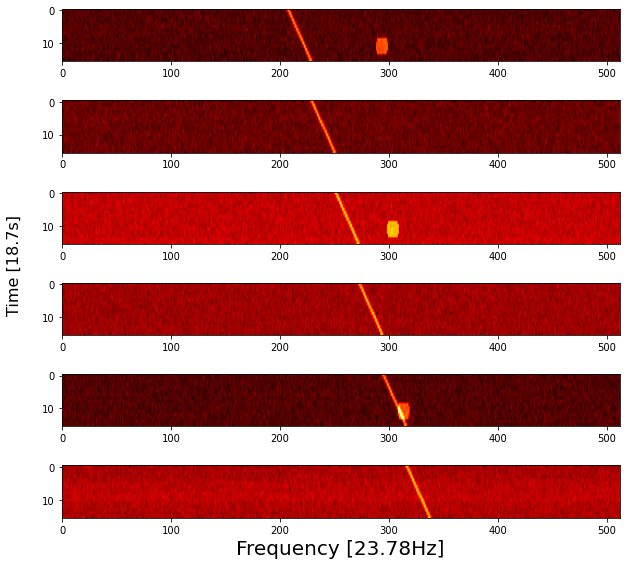

In [84]:
mask =np.zeros(false_data_train.shape)
for i in range(false_data_train.shape[0]):
    mask[i, :,:,:,0]=false_data_train[i, :,:,:,0] + draw_shape()
mask[1, :,:,:,0] = mask[1, :,:,:,0]
plot_cadence(mask[0, :,:,:,0])

In [21]:
print(false_data_test[1, 0,:,:,0].min())
print(false_data_test[1, 1,:,:,0].min())
print(data.min())

0.0
0.23433414921110515


NameError: name 'data' is not defined

# Outsample Conv Net

In [43]:
from sklearn import metrics

fpr_cnn_out, tpr_cnn_out, _ = metrics.roc_curve(test_labels,   model_conv.predict(test_out))
auc_conv_out = metrics.roc_auc_score(test_labels,   model_conv.predict(test_out))
print(auc_conv_out)

0.8892289444444444


# Outsample 002 Algorithm

In [44]:
import joblib
from execute_model import model_load

model_name = "../test_bench/VAE-BLPC1-ENCODER_compressed_512v13-0"
zeroTwo = model_load(model_name+".h5")
forest = joblib.load('../test_bench/random_forest_1000_v4.joblib')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
tensorflow      INFO     Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
tensorflow      WARNING  No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


In [45]:
frame_list = []
for i in range(test.shape[0]):
    print(i)
    frame_list.append(zeroTwo.predict(test_out[i,:,:,:,:])[2].ravel())
frame_list = np.array(frame_list)
probs_list = forest.predict_proba(frame_list)[:, 1]
print(probs_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338


In [46]:
fpr_002_out, tpr_002_out, _ = metrics.roc_curve(test_labels,  probs_list)
auc_002_out= metrics.roc_auc_score(test_labels, probs_list)
print(auc_002_out)

0.9176940555555556


# ROC Outsample

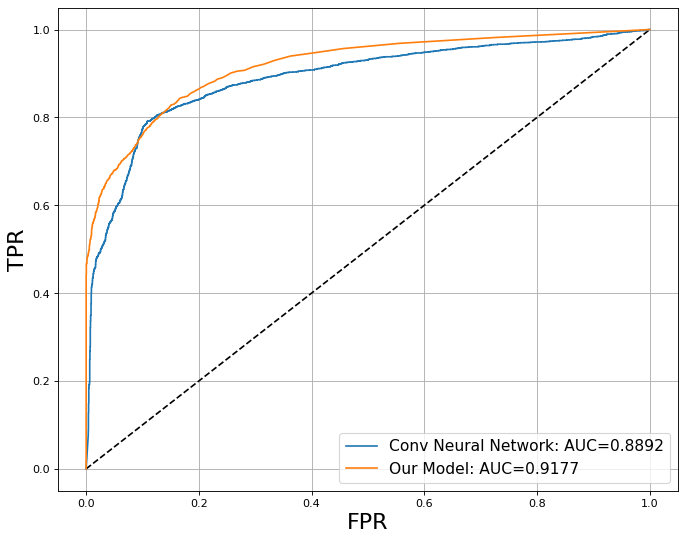

In [51]:
%matplotlib inline

plt.figure(figsize=(10, 8), dpi=80)
plt.plot([0,1],[0,1], 'k--')

plt.plot(fpr_cnn_out, tpr_cnn_out, label= "Conv Neural Network: AUC="+str(round(auc_conv_out,4)))
plt.plot(fpr_002_out, tpr_002_out, label= "Our Model: AUC="+str(round(auc_002_out,4)))         
plt.legend(fontsize=14)
plt.xlabel("FPR", fontsize=20)
plt.ylabel("TPR", fontsize=20)
plt.grid()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  import sys


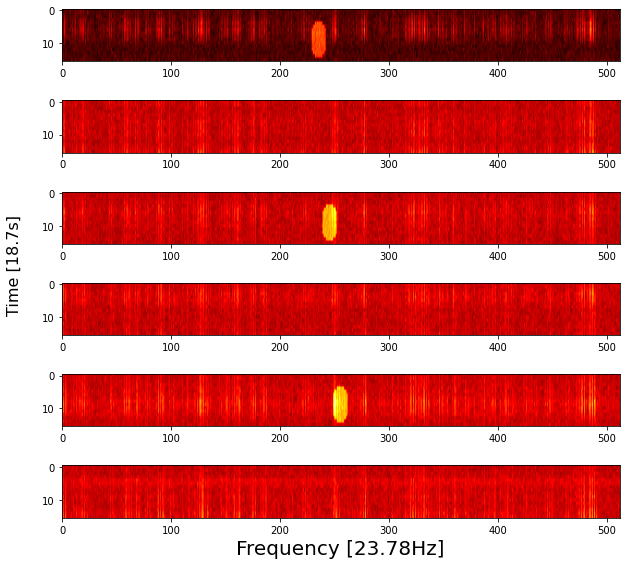

In [14]:
%matplotlib inline
def plot_cadence(data):
    fig, ax = plt.subplots(6, 1, figsize=(10,10))
    fig.subplots_adjust(hspace = .05, wspace=.001)
#     fig.suptitle('Cadence Snippet', fontsize=16)
    for i in range(6):
        ax[i].imshow(data[i,:,:], CMAP='hot',aspect=3, vmin = data.min(), vmax = data.max())
#         ax[i].set_ylabel('Time Bins [18s]', fontsize=23)
        if i==5:
            ax[i].set_xlabel('Frequency [23.78Hz]', fontsize=20)
    fig.text(0.06, 0.5, 'Time [18.7s]', ha='center', va='center', rotation='vertical',  fontsize=16)
    plt.show()

plot_cadence(mask[1, :,:,:,0])